# Capstone Project: Classifying clinically actionable genetic mutations

***

# Step 3: Modelling

## Importing of Libraries

In [2]:
# pip install imblearn

In [3]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

from imblearn.over_sampling import SMOTE

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

import nltk
from nltk.tokenize import RegexpTokenizer
import regex as re
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

from collections import Counter
from wordcloud import WordCloud

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

C:\Users\yuchy\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data Import

In [4]:
# import 'train_prep' and 'test_prep' datasets
train = pd.read_csv("../datasets/train_prep.csv", keep_default_na=False)
test = pd.read_csv("../datasets/test_prep.csv", keep_default_na=False)

In [5]:
train.shape, test.shape

((3321, 5), (5668, 4))

In [6]:
train.head()

id    gene             variation  class  \
0   0  FAM58A  Truncating Mutations      1   
1   1     CBL                 W802*      2   
2   2     CBL                 Q249E      2   
3   3     CBL                 N454D      3   
4   4     CBL                 L399V      4   

                                                text  
0  cyclin dependent kinase cdks regulate variety ...  
1  abstract background non small lung cancer nscl...  
2  abstract background non small lung cancer nscl...  
3  recent evidence ha demonstrated acquired unipa...  
4  oncogenic monomeric casitas b lineage lymphoma...

In [7]:
test.head()

id     gene variation                                               text
0   0    ACSL4     R570S  resulted myeloproliferative phenotype includin...
1   1    NAGLU     P521L  abstract large suppressor lat serine threonine...
2   2      PAH     L333F  vascular endothelial growth factor receptor ve...
3   3     ING1     A148D  inflammatory myofibroblastic imt neoplasm typi...
4   4  TMEM216      G77A  abstract retinoblastoma pediatric retinal init...

## Splitting of data into Predictor (X) and Target (y) Dataframes

In [8]:
X = train[[i for i in train.columns if i not in ['class']]]
y = train['class']

In [9]:
X.shape, y.shape

((3321, 4), (3321,))

## Creation of dummy columns

In [10]:
X = pd.get_dummies(X, columns=['gene', 'variation'], drop_first=False)

In [11]:
X.shape

(3321, 3262)

In [12]:
X.head()

id                                               text  gene_ABL1  \
0   0  cyclin dependent kinase cdks regulate variety ...          0   
1   1  abstract background non small lung cancer nscl...          0   
2   2  abstract background non small lung cancer nscl...          0   
3   3  recent evidence ha demonstrated acquired unipa...          0   
4   4  oncogenic monomeric casitas b lineage lymphoma...          0   

   gene_ACVR1  gene_AGO2  gene_AKT1  gene_AKT2  gene_AKT3  gene_ALK  gene_APC  \
0           0          0          0          0          0         0         0   
1           0          0          0          0          0         0         0   
2           0          0          0          0          0         0         0   
3           0          0          0          0          0         0         0   
4           0          0          0          0          0         0         0   

   ...  variation_Y87N  variation_Y901C  variation_Y931C  variation_Y98H  \
0  ...               0                0                0               0   
1  ...               0                0                0               0   
2  ...               0                0                0               0   
3  ...               0                0                0               0   
4  ...               0                0                0               0   

   variation_Y98N  variation_YAP1-FAM118B Fusion  \
0               0                              0   
1               0                              0   
2               0                              0   
3               0                              0   
4               0                              0   

   variation_YAP1-MAMLD1 Fusion  variation_ZC3H7B-BCOR Fusion  \
0                             0                             0   
1                             0                             0   
2                             0                             0   
3                             0                             0   
4                             0                             0   

   variation_ZNF198-FGFR1 Fusion  variation_p61BRAF  
0                              0                  0  
1                              0                  0  
2                              0                  0  
3                              0                  0  
4                              0                  0  

[5 rows x 3262 columns]

## Creation of (Inner) Training and Validation Datasets

From our single training data set (X and y) we will create two separate datasets:
- (Inner) Training Dataset: this will be used to train our models (this will take 75% of the original training dataset)
- Validation Dataset: this will be used to validate our trained models (e.g. check for overfitting) (this will take 25% of our total 'posts' dataset

To create our datasets, we use train_test_split with the stratify option to ensure a consistent mix of values for the target feature within the created datasets.

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, stratify=y)

In [14]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((2490, 3262), (2490,), (831, 3262), (831,))

In [15]:
X_train.reset_index(inplace=True)
X_val.reset_index(inplace=True)

## Tokenisation using CountVectorizer

The CountVectorizer provides a simple way to tokenise a collection of text documents, build a vocabulary of known words and  encode new documents using that vocabulary. CountVectorizer will transform the lists of text into features that we can pass into a model. It will create columns (also knon as vectors), where each column counts how many times each word is observed in each descriptive text string.

In [16]:
# Instantiate a CountVectorizer object
cvec = CountVectorizer(stop_words='english')

In [17]:
%%time
X_train_cvec = cvec.fit_transform(X_train['text'])
X_val_cvec = cvec.transform(X_val['text'])

Wall time: 11.9 s


In [18]:
X_train_cvec.shape, X_val_cvec.shape

((2490, 74865), (831, 74865))

In [19]:
X_train_cvec_df = pd.DataFrame(X_train_cvec.toarray(), columns=cvec.get_feature_names())
X_val_cvec_df = pd.DataFrame(X_val_cvec.toarray(), columns=cvec.get_feature_names())

In [20]:
X_train_cvec_df.shape, X_val_cvec_df.shape

((2490, 74865), (831, 74865))

In [21]:
X_train_cvec_df.head()

aa  aaa  aaaa  aaaaa  aaaaaagaaaattttagataaaaagag  \
0   0    0     0      0                            0   
1   0    0     0      0                            0   
2   0    0     0      0                            0   
3   0    0     0      0                            0   
4   0    0     0      0                            0   

   aaaaaatcccaaccataacaaaattt  aaaaaatcctcttgtgttcag  \
0                           0                      0   
1                           0                      0   
2                           0                      0   
3                           0                      0   
4                           0                      0   

   aaaaaccggtatgaaaagcagcataccgaacaataaggagatccc  aaaaag  aaaaataactactgc  \
0                                              0       0                0   
1                                              0       0                0   
2                                              0       0                0   
3                                              0       0                0   
4                                              0       0                0   

   ...  zytolight  zytomed  zytovision  zyx  zyxin  zz  zzo  zzq  zzsi  zzzq  
0  ...          0        0           0    0      0   0    0    0     0     0  
1  ...          0        0           0    0      0   0    0    0     0     0  
2  ...          0        0           0    0      0   0    0    0     0     0  
3  ...          0        0           0    0      0   0    0    0     0     0  
4  ...          0        0           0    0      0   0    0    0     0     0  

[5 rows x 74865 columns]

In [22]:
# Concatenate the components parts of the dataframe
X_train = pd.concat([X_train, X_train_cvec_df], axis=1)
X_val = pd.concat([X_val, X_val_cvec_df], axis=1)

In [23]:
X_train.drop(columns=['index', 'id', 'text'], inplace=True)
X_val.drop(columns=['index', 'id', 'text'], inplace=True)

In [24]:
X_train.shape, X_val.shape

((2490, 78122), (831, 78122))

## <mark>Handling of imbalanced classes</mark>

In [25]:
# y_train.value_counts(normalize=True)

We note above that the **training set is highly imbalanced** -- i.e. classes 4 and 7 alone take up almost 50% of all classes found in the training set.

To deal with this, we will need to oversample the minority classes rather than undersample the majority classes as the latter will remove valuable data for our modelling.

We oversample by creating synthetic samples using imblearn’s SMOTE or Synthetic Minority Oversampling Technique. SMOTE uses a nearest neighbors algorithm to generate new and synthetic data we can use for training our model. We generate new samples **only in the training set** to ensure our model generalises well to unseen data.

In [26]:
# Instantiate a SMOTE object to oversample minority classes
# sm = SMOTE(random_state=42) 

In [27]:
# %%time
# X_train, y_train = sm.fit_sample(X_train, y_train)

In [28]:
# X_train.shape, y_train.shape

In [29]:
# y_train.value_counts()

As shown above, the oversampling has been successful - there are now an equal number of data points for each 'class'.

## Creation of Baseline Model

We train, visualise and evaluate both a random forest classifier and multinomial logistic regression classifier.

### Training of Random Forest Classifier

In [30]:
rfc = RandomForestClassifier(random_state = 42, n_jobs=-1, verbose=1)

In [31]:
%%time
rfc_params = {
    'n_estimators': [200, 250, 300],
    'class_weight': ['balanced'], # 'balanced' will help to deal with our imbalanced classes
    'min_samples_split':[5,10,15,20],
    'min_samples_leaf':[2,3,4,5]
}
rs_rfc = RandomizedSearchCV(rfc, param_distributions=rfc_params,\
                            random_state=42, cv=5, verbose=1, n_jobs=-1)
rs_rfc.fit(X_train, y_train)
print(rs_rfc.best_score_)
rs_rfc.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  5.3min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    6.5s finished


0.6433734939759036
Wall time: 5min 26s


{'n_estimators': 250,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'class_weight': 'balanced'}

### Visualisation of Random Forest Classifier

We now visualise one particular decision tree in the random forest, arbitrarily.

In [33]:
estimator = rs_rfc.best_estimator_[100] # we choose one particular tree arbitrarily)

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = X_train.columns,
                class_names = list(str(range(1,10))),
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using Graphviz via system command
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

### Evaluation of Random Forest Classifier

#### Scoring on Training Set

In [52]:
print ("Score on training set: {}".format(rs_rfc.score(X_train, y_train)))

Score on training set: 0.8859437751004016


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed:    0.0s finished


#### Scoring on Validation Set

In [51]:
print ("Score on validation set: {}".format(rs_rfc.score(X_val, y_val)))

Score on validation set: 0.6221419975932612


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed:    0.0s finished


The random forest classifier appears to be overfitted based on the lower score for the validation dataset compared to the training dataset.

In [34]:
probabilities = rs_rfc.predict_proba(X_val)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed:    0.0s finished


In [37]:
# Show AUC score based on One versus One (OVO) algorithm
# for multi-label classification
metrics.roc_auc_score(y_val, probabilities, average="weighted", multi_class="ovo")

0.8624467126563775

<mark>**Calculate sensitivity score**</mark>

<mark>**Plot ROC curve**</mark>

### Training of Multinomial Logistic Regression Classifier

We scale the word counts before we train the logistic regression classifier.

In [47]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_val_sc = ss.transform(X_val)

In [58]:
# X_train_sc.shape

(2490, 78122)

In [59]:
# X_train.shape

(2490, 78122)

We now train the classifier.

In [39]:
logreg = LogisticRegression(random_state = 42, n_jobs=-1, verbose=1)

In [40]:
%%time
# We explicitly specify the 'multi_class" parameter to be ‘multinomial’
# to indicate that we want the minimised loss to be the multinomial loss
# fit across the entire probability distribution
logreg_params = {
    'penalty':['l1','l2','elasticnet'],
    'solver':['newton-cg','lbfgs','sag','saga'],
    'multi_class':['multinomial'], 
    'C': np.logspace(-3, 1, 5)
}
rs_logreg = RandomizedSearchCV(logreg, param_distributions=logreg_params,\
                            random_state=42, cv=5, verbose=1, n_jobs=-1)
rs_logreg.fit(X_train_sc, y_train)
print(rs_logreg.best_score_)
rs_logreg.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 769.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  3.9min finished


0.6092369477911647
Wall time: 12h 53min 16s


{'solver': 'lbfgs', 'penalty': 'l2', 'multi_class': 'multinomial', 'C': 0.001}

### Visualisation of Multinomial Logistic Regression Classifier

We now visualise the coefficients of the trained classifier, for class = 7, which is the most frequently occuring class.

In [42]:
logreg_coef = rs_logreg.best_estimator_

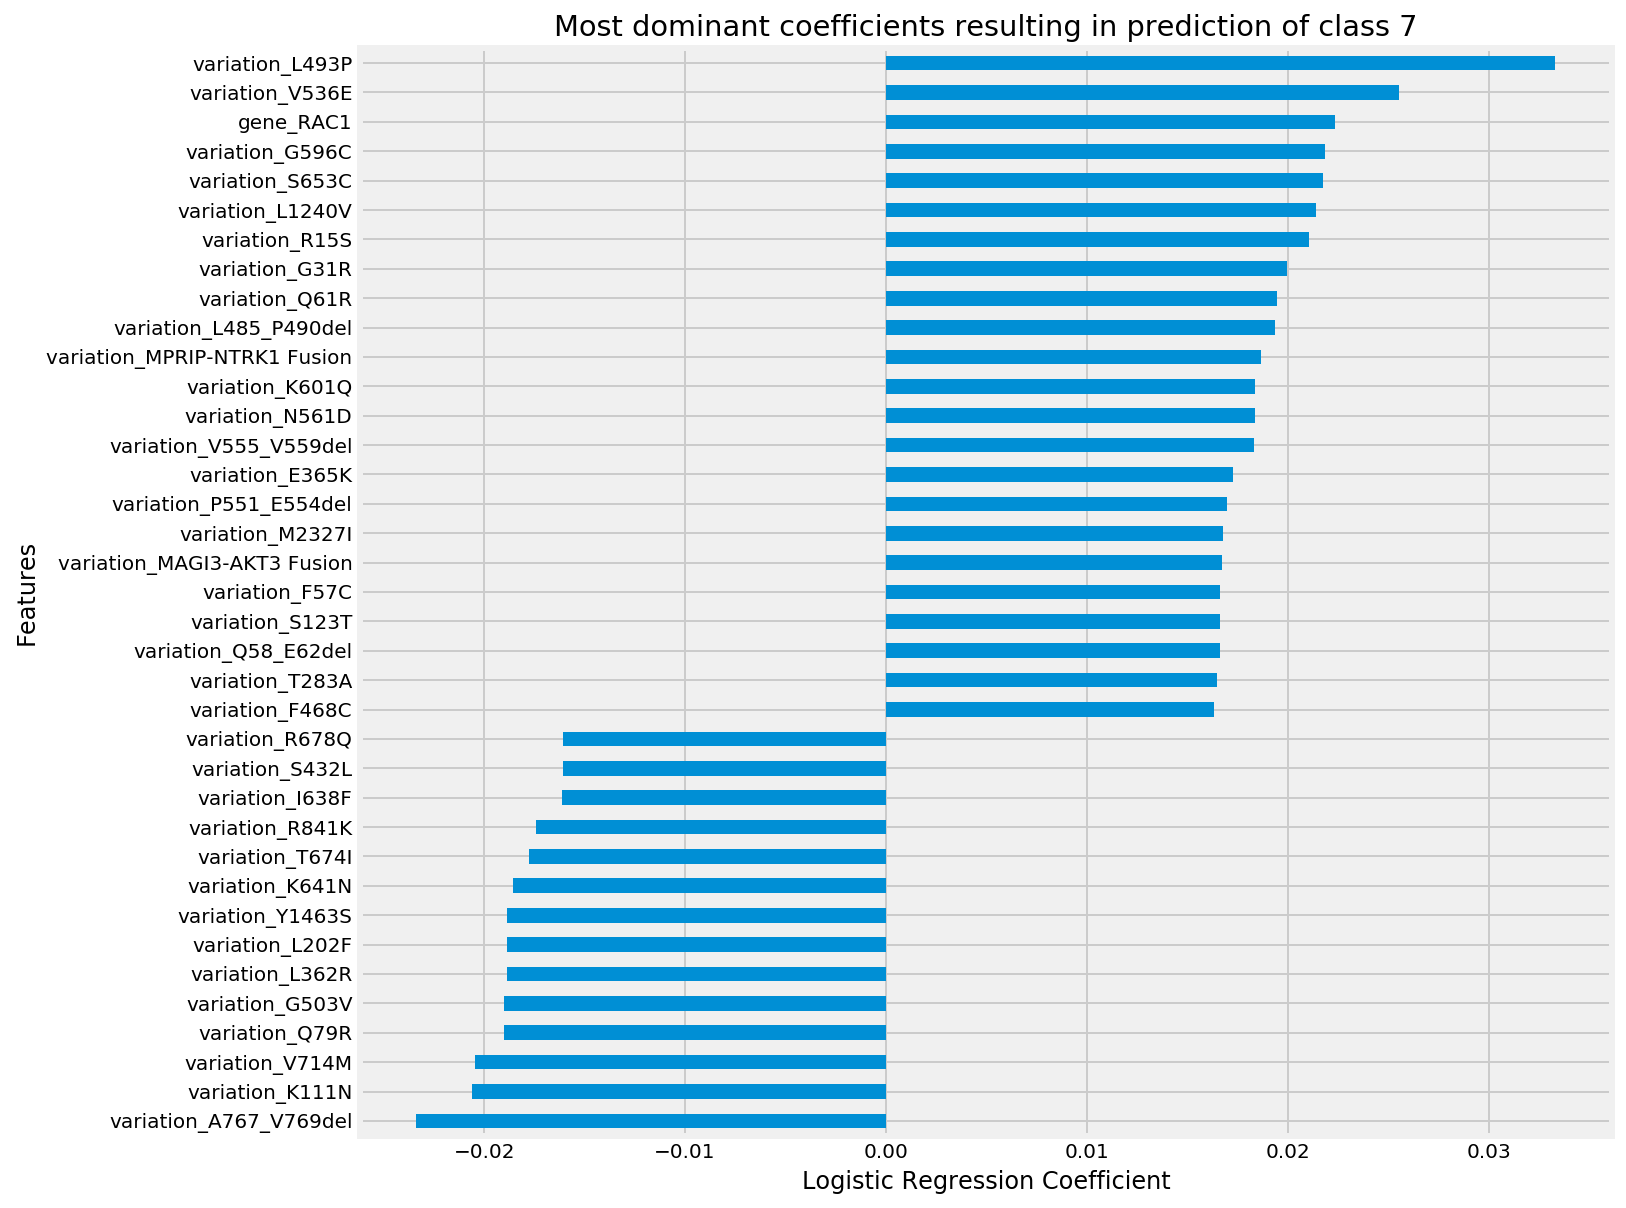

In [153]:
fig = plt.figure(figsize=(10,10))
feature_scores = pd.DataFrame(logreg_coef.coef_[6].reshape(1,-1), columns=X_train.columns)
feature_scores.loc[0,feature_scores.iloc[0,:].abs() >0.016].\
    sort_values(ascending=True).plot(kind='barh');
plt.xlabel("Logistic Regression Coefficient")
plt.ylabel("Features")
plt.title("Most dominant coefficients resulting in prediction of class 7");

The following are the top 10 coefficient names and values leading to the prediction of each class.

In [152]:
for cl in range(0,9):
    scores = pd.DataFrame(logreg_coef.coef_, columns=X_train.columns)
    print("--------------------------------------------------------------------")
    print("Top 10 coefficient names and values leading to prediction of class {}".format(cl+1))
    print("--------------------------------------------------------------------")
    print(scores.loc[cl,scores.loc[cl,:].abs().sort_values(ascending=False).head(10).index.tolist()])
    print("\n")

--------------------------------------------------------------------
Top 10 coefficient names and values leading to prediction of class 1
--------------------------------------------------------------------
variation_H1686R                  0.034349
variation_V1688del                0.034349
variation_W349C                   0.026786
variation_G637W                   0.026587
variation_D617G                   0.026587
variation_R421*                   0.026067
variation_S1088F                  0.025874
gene_ARID5B                       0.025867
variation_R80P                    0.025794
variation_Truncating Mutations    0.025171
Name: 0, dtype: float64


--------------------------------------------------------------------
Top 10 coefficient names and values leading to prediction of class 2
--------------------------------------------------------------------
variation_V561A           0.028541
variation_S121A           0.026453
variation_E267G           0.026095
variation_A767_V769del   

### Evaluation of Multinomial Logistic Regression Classifier

#### Scoring on Training Set

In [53]:
print ("Score on training set: {}".format(rs_logreg.score(X_train_sc, y_train)))

Score on training set: 0.9931726907630523


#### Scoring on Validation Set

In [54]:
print ("Score on validation set: {}".format(rs_logreg.score(X_val_sc, y_val)))

Score on validation set: 0.6137184115523465


The logistic regression classifier appears to be overfitted based on the lower score for the validation dataset compared to the training dataset.

In [56]:
probabilities = rs_logreg.predict_proba(X_val)

In [57]:
# Show AUC score based on One versus One (OVO) algorithm for multi-label classification
metrics.roc_auc_score(y_val, probabilities, average="weighted", multi_class="ovo")

0.7887007314510952

<mark>**Calculate sensitivity score**</mark>

<mark>**Plot ROC curve**</mark>

### Selection of Baseline Model

### Further exploration of Baseline Model

## Creation of Alternative Model based on xxx

### Selection of Alternative Model

### Further exploration of Alternative Model